# Analyzing Ford GoBike Trip Statistics for San Franscisco Bay Area 2017-2018

## Creator: Tom Esposito, espos13@gmail.com, http://w.astro.berkeley.edu/~tesposito/

### This notebook analyzes ride data from the Ford GoBike bikeshare program operated in the San Francisco Bay Area by Motivate. My analysis focuses on the city of Berkeley, where I live, but extends to Oakland, Emeryville, San Francisco, and San Jose. It uses publicly available data from https://www.fordgobike.com/system-data and open-source Python code to examine ridership statistics.

### Acknowledgements: Thank you to Motivate for making their data public and nicely packaged. Thank you also to the authors and developers of the public Python packages `geocoder` (https://github.com/DenisCarriere/geocoder), `gmplot` (https://github.com/vgm64/gmplot), `requests` (http://docs.python-requests.org/en/master/), `astropy` (http://www.astropy.org), and `matplotlib` (https://matplotlib.org).

#### Disclaimer: This work is conducted purely to satisfy personal curiosity. I am not affiliated with Motivate, its parent company Lyft, Inc., or Ford Motor Company, nor am I affiliated with any of the municipalities participating in the GoBike program apart from being a resident of Berkeley.

## Load and parse the data

In [1]:
import glob
import time
import requests
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geocoder
from gmplot import gmplot
# I'm using table-handling functions from astropy, an astronomy-related module, because I'm
# familiar with it, but there are other options out there.
from astropy import table
from astropy.io import ascii

# Set some plotting defaults.
font = {'size' : 14}
matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

We have GoBike ride data as comma-separated tables with annual totals for 2017 (not intrinsically broken down by month) and monthly totals for January through June 2018. That gives us data for seven different epochs, i.e. periods of time.

In [4]:
# Get the paths to available .csv tables containing GoBike data based on epoch names.
epoch_names = ['2017', '201801', '201802', '201803', '201804', '201805', '201806']

filenames = ['%s-fordgobike-tripdata.csv' % epoch for epoch in epoch_names]

print("Epoch names:", epoch_names)

# Read the files into handy tables using astropy.io.ascii.
# Convert the 'NULL' empty entries to -1 for easier handling later.
# This will take ~10 seconds.
tables = [ascii.read(fn, Reader=ascii.Basic,
                      delimiter=',', header_start=0, data_start=1,
                      fill_values=[('NULL', -1)]) for fn in filenames]

Epoch names: ['2017', '201801', '201802', '201803', '201804', '201805', '201806']


For assessing trip statistics city-by-city, I want to know which city each station is in. Unfortunately, the city name is not included with the station names. But we do have the station latitudes and longitudes! With the help of the `geocoder` module and a geocoding API we can use those coordinates to match a city to each station. In this case, we used the [Nominatim](https://nominatim.openstreetmap.org) server connected to the open-license [OpenStreetMap](https://www.openstreetmap.org/#map=10/37.6523/-122.2998) to reverse geocode every unique (latitude,longitude) pair and fetch the city name.

We did this once and saved the result in a table named "stations.tsv" to avoid repeated querying, which is slow and a burden on the Nominatim servers. See the commented code below for the method. If you wish to do your own queries, please read and abide by the [Nominatim usage policy](https://operations.osmfoundation.org/policies/nominatim/) so they can keep providing this free service.

In [5]:
# Load the table of stations and city names created ahead of time.
# Column names: 'id', 'name', 'city', 'lat', 'lon'
stations = ascii.read("stations.tsv", Reader=ascii.Basic,
                      delimiter='\t', header_start=0, data_start=1)

```
# ----- EXAMPLE REVERSE GEOCODING ----- #

# Get all unique station latitude,longitude coordinate pairs from the most recent epoch,
# by the reasoning that stations have been added over time but not taken away.
# This is slightly slow due to the repeated table lookup; it takes ~25 seconds.

tab_1806 = tables[-1]
start_stations = np.unique(np.array(tab_1806['start_station_id', 'start_station_latitude', 'start_station_longitude', 'start_station_name']))
end_stations = np.unique(np.array(tab_1806['end_station_id', 'end_station_latitude', 'end_station_longitude', 'end_station_name']))

# Make a new empty table to hold all of our station info.
stations = table.Table(names=['id', 'name', 'city', 'lat', 'lon'],
                       dtype=['int64', 'U80', 'U50', 'float64', 'float64'])

# Loop through the starting stations to find out which cities they're in.
# This could take up to 1 hour or more for ~300 station queries.
# First, create a persistent HTTP connection with requests.Session to reuse the same
# TCP connection for every query to Nominatim and speed things up (maybe).

with requests.Session() as session:
    for st in start_stations:
        if st[0] != -1:
            sid = st[0]
            lat = st[1]
            lon = st[2]
            geo = geocoder.osm('%s,%s' % (lat, lon), method='reverse', session=session)
            # Nominatim returns the city name in one of several class attributes. Use whichever is not None.
            # E.g., Emeryville is a 'town' instead of a 'city', despite it actually being the latter.
            city_names = np.array([geo.current_result.city, geo.current_result.town,
                                   geo.current_result.village, geo.current_result.municipality])
            city = city_names[np.argwhere(city_names)[0][0]] # string name of city
            stations.add_row([sid, st[3], city, lat, lon])
            print(geo)
            # The Nominatim rate limit for bulk queries is 1/second, so make sure we stay below that limit.
            time.sleep(1)

    # Loop through the end stations to add any not included in the starting stations.
    for st in end_stations:
        if ((st[0] != -1) & (st[0] not in stations['id'])):
            print("Found new end station")
            sid = st[0]
            lat = st[1]
            lon = st[2]
            geo = geocoder.osm('%s,%s' % (lat, lon), method='reverse', session=session)
            city_names = np.array([geo.current_result.city, geo.current_result.town,
                                   geo.current_result.village, geo.current_result.municipality])
            city = city_names[np.argwhere(city_names)[0][0]]
            stations.add_row([sid, st[3], city, lat, lon])
            print(geo)
            time.sleep(1)

# Write the new table to a file to avoid geocoding again.
stations.write('stations.tsv', format='ascii.tab')
```

In [6]:
# Add the city names of the starting and ending stations as new columns in each table
# so we have them handy later.
# Doing this station-by-station with for loops is slow but effective.
for tab in tables:
    tab.add_column(table.Column(len(tab)*[''], name='start_city', dtype='U50'))
    tab.add_column(table.Column(len(tab)*[''], name='end_city', dtype='U50'))
    
    for row in stations:
        row_id = row['id']
        row_city = row['city']
        tab['start_city'][tab['start_station_id']==row_id] = row_city
        tab['end_city'][tab['end_station_id']==row_id] = row_city

In [7]:
# FIX ME!!! This takes ~40 seconds. Speed it up.

# I'd like to compare weekday trips to weekend trips at some point. This will require parsing the
# "start_time" and "end_time" strings into new table columns for day and 24-hour time.
# Writing to table elements is slow, so we'll stage our new entries in arrays and put them
# into the table columns only as a final step.

# The datetime.weekday() method returns an integer 0-6 with 0 = Monday and 6 = Sunday.
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for tab in tables:
    #tab.add_column(table.Column(len(tab)*[''], name='start_day', dtype='U50'))
    #tab.add_column(table.Column(len(tab)*[-1], name='start_hr', dtype='float32'))
    #tab.add_column(table.Column(len(tab)*[''], name='end_day', dtype='U50'))
    #tab.add_column(table.Column(len(tab)*[-1], name='end_hr', dtype='float32'))
    
    #for row in tab:
    #    start_parsed = datetime.strptime(row['start_time'], "%Y-%m-%d %H:%M:%S.%f")
    #    end_parsed = datetime.strptime(row['end_time'], "%Y-%m-%d %H:%M:%S.%f")
    #    row['start_day'] = days_of_week[start_parsed.weekday()]
    #    row['end_day'] = days_of_week[end_parsed.weekday()]
    #    row['start_hr'] = start_parsed.hour + start_parsed.minute/60.
    #    row['end_hr'] = end_parsed.hour + end_parsed.minute/60.
    
    start_dt = [datetime.strptime(st, "%Y-%m-%d %H:%M:%S.%f") for st in tab['start_time'].data]
    start_days = np.array([days_of_week[ii.weekday()] for ii in start_dt])
    start_hrs = np.array([ii.hour + ii.minute/60. for ii in start_dt])
    end_dt = [datetime.strptime(et, "%Y-%m-%d %H:%M:%S.%f") for et in tab['end_time'].data]
    end_days = np.array([days_of_week[ii.weekday()] for ii in end_dt])
    end_hrs = np.array([ii.hour + ii.minute/60. for ii in end_dt])
    
    tab.add_column(table.Column(start_days, name='start_day', dtype='U50'))
    tab.add_column(table.Column(start_hrs, name='start_hr', dtype='float32'))
    tab.add_column(table.Column(end_days, name='end_day', dtype='U50'))
    tab.add_column(table.Column(end_hrs, name='end_hr', dtype='float32'))

In [8]:
# Separate out the stations that are in Berkeley.
berk_stations = stations[stations['city'] == 'Berkeley']
berk_ids = berk_stations['id'].tolist()

In [9]:
# Define a function to separate the trips involving a single city in a trip table
# from a given epoch.
def sep_city(tab, city_ids):
    wh_start = []
    wh_end = []
    for sid in city_ids:
        wh_start += (np.where(tab['start_station_id'] == sid)[0].tolist())
        wh_end += (np.where(tab['end_station_id'] == sid)[0].tolist())
    
    city_start = tab[wh_start]
    city_end = tab[wh_end]
    
    # Combine the Berkeley start and end trips to get all trips starting or ending in the city.
    wh_city = np.unique(wh_start + wh_end)
    city_trips = tab[wh_city]
    
    # And find the trips that both started AND ended in Berkeley.
    wh_city_only = np.array(wh_start)[np.in1d(wh_start, wh_end)]
    city_only = tab[wh_city_only]
    
    return city_trips, city_only, city_start, city_end

In [10]:
# Now we can easily separate out the trips that start and/or end in Berkeley.
# berk_trip_list will be a list of tuples of tables for each epoch of data.
berk_trip_list = []
for ii, tab in enumerate(tables):
    berk_trip_list.append(sep_city(tab, berk_ids))

Before going further we will do some basic accounting to make sure the city trip numbers make sense. For reference, the 2010 census listed Berkeley's population at 112,580.

To put the 2017 data on the same scale as the monthly 2018 data, we'll divide the 2017 numbers by 6 to get a monthly average for that year (the program started that June 28).

In [11]:
# Let's do some simple accounting to make sure these trip numbers make sense.
pop_berk = 112580

n_berk_trips = []
n_berk_only = []
n_berk_start = []
n_berk_end = []
for ii in range(len(berk_trip_list)):
    n_berk_trips.append(len(berk_trip_list[ii][0]))
    n_berk_only.append(len(berk_trip_list[ii][1]))
    n_berk_start.append(len(berk_trip_list[ii][2]))
    n_berk_end.append(len(berk_trip_list[ii][3]))
    
    if ii == 0:
        n_berk_trips[ii] /= 6.
        n_berk_only[ii] /= 6.
        n_berk_start[ii] /= 6.
        n_berk_end[ii] /= 6.
    
    print(filenames[ii].split('-')[0])
    print("# trips starting in Berkeley = %d" % n_berk_start[ii])
    print("# trips ending in Berkeley   = %d" % n_berk_end[ii])
    print("# trips starting OR ending in Berkeley  = %d" % n_berk_trips[ii])
    print("# trips starting AND ending in Berkeley = %d" % n_berk_only[ii])

2017
# trips starting in Berkeley = 2489
# trips ending in Berkeley   = 2301
# trips starting OR ending in Berkeley  = 2952
# trips starting AND ending in Berkeley = 1839
201801
# trips starting in Berkeley = 4697
# trips ending in Berkeley   = 4389
# trips starting OR ending in Berkeley  = 5423
# trips starting AND ending in Berkeley = 3663
201802
# trips starting in Berkeley = 6675
# trips ending in Berkeley   = 6325
# trips starting OR ending in Berkeley  = 7574
# trips starting AND ending in Berkeley = 5426
201803
# trips starting in Berkeley = 6597
# trips ending in Berkeley   = 6231
# trips starting OR ending in Berkeley  = 7505
# trips starting AND ending in Berkeley = 5323
201804
# trips starting in Berkeley = 8798
# trips ending in Berkeley   = 8438
# trips starting OR ending in Berkeley  = 9900
# trips starting AND ending in Berkeley = 7336
201805
# trips starting in Berkeley = 10530
# trips ending in Berkeley   = 10057
# trips starting OR ending in Berkeley  = 11952
# trips 

### Berkeley Trip Numbers

Now we can examine actual numbers for trips related to Berkeley through plots and statistical methods.

We don't have an estimate of the uncertainties on the trip data from GoBike, so we'll assume a (somewhat arbitrary) 5% margin of error on all trips recorded. This basically implies that 1 out of every 20 trips is recorded inaccurately, on average. Maybe a bit pessimistic, but being conservative will help keep us from overinterpreting our data.

First we will compare how many trips of two different types were made in each month of 2018: trips starting but not ending in Berkeley ("starts"), ending but not starting in Berkeley ("ends"), starting or ending in Berkeley ("start/end"), and roundtrips within Berkeley ("roundtrips").

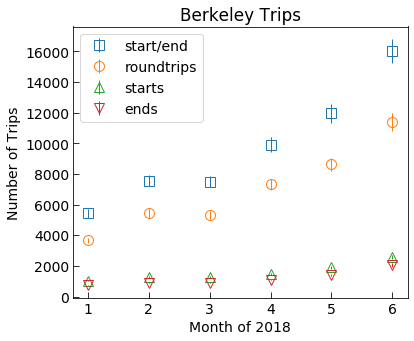

In [12]:
# Separate out the "starts" and "ends" from the "start/ends".
berk_startonly_list = [berk_trip_list[ii][0][((berk_trip_list[ii][0]['start_city']=='Berkeley') & (berk_trip_list[ii][0]['end_city']!='Berkeley'))] for ii in range(len(berk_trip_list))]
n_berk_startonly = [len(tab) for tab in berk_startonly_list]
berk_endonly_list = [berk_trip_list[ii][0][((berk_trip_list[ii][0]['end_city']=='Berkeley') & (berk_trip_list[ii][0]['start_city']!='Berkeley'))] for ii in range(len(berk_trip_list))]
n_berk_endonly = [len(tab) for tab in berk_endonly_list]

ms = 10 # markersize
plt.figure(figsize=(6,5))
plt.errorbar(range(1,7), n_berk_trips[1:], yerr=np.array(n_berk_trips[1:])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(1,7), n_berk_only[1:], yerr=np.array(n_berk_only[1:])*0.05,
             label='roundtrips', color='C1', marker='o', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(1,7), n_berk_startonly[1:], yerr=np.array(n_berk_startonly[1:])*0.05,
             label='starts', color='C2', marker='^', markersize=ms, markerfacecolor='None', linestyle='None')
plt.errorbar(range(1,7), n_berk_endonly[1:], yerr=np.array(n_berk_endonly[1:])*0.05,
             label='ends', color='C3', marker='v', markersize=ms, markerfacecolor='None', linestyle='None')
plt.title("Berkeley Trips")
plt.ylabel("Number of Trips")
plt.xlabel("Month of 2018")
plt.legend(numpoints=1)
plt.show()

Ridership is clearly increasing over time. We'll need to fit a function to these data to find out just how quickly it's increasing and predict future ridership numbers.

The simplest function is a straight line: *y = ax + b*. We'll also try a basic exponential of the form *y = c + a exp(bx)*. We'll compare the goodness of fit with a simple $\chi^2_\nu$ (reduced chi-squared), where a smaller number represents a "better" fit and $\chi^2_\nu$=1.0 is a theoretically perfect fit.

Reduced chi^2, lin. fit = 5.332
Reduced chi^2, exp. fit = 2.240


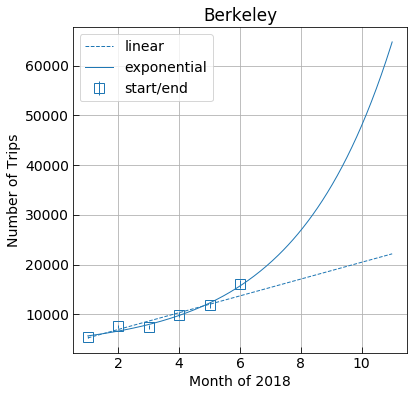

In [31]:
from scipy.optimize import curve_fit
pf_lin, cov_lin = curve_fit(lambda t,a,b: a*t+b,  np.arange(1.,7.),  n_berk_trips[1:],
          sigma=np.array(n_berk_trips[1:])*0.05, p0=(1500., 3500.))
pf_exp, cov_exp = curve_fit(lambda t,a,b,c: c + a*np.exp(b*t),  range(1,7),  n_berk_trips[1:],
          sigma=np.array(n_berk_trips[1:])*0.05, p0=(700., 0.45, 5000.))

fit_lin = pf_lin[0]*np.arange(1.,7.) + pf_lin[1]
fit_exp = pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*np.arange(1.,7.))

chi2_red_lin = np.sum(((n_berk_trips[1:] - fit_lin)/(np.array(n_berk_trips[1:])*0.05))**2)/(6 - 2)
chi2_red_exp = np.sum(((n_berk_trips[1:] - fit_exp)/(np.array(n_berk_trips[1:])*0.05))**2)/(6 - 2)
print("Reduced chi^2, lin. fit = %.3f" % chi2_red_lin)
print("Reduced chi^2, exp. fit = %.3f" % chi2_red_exp)

t_extrap = np.linspace(1., 11., 250)
plt.figure(figsize=(6,6))
plt.errorbar(range(1,7), n_berk_trips[1:], yerr=np.array(n_berk_trips[1:])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
plt.plot(t_extrap, pf_lin[0]*t_extrap + pf_lin[1], color='C0', linestyle='--', label='linear')
plt.plot(t_extrap, pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*t_extrap), label='exponential')
plt.ylabel("Number of Trips")
plt.xlabel("Month of 2018")
plt.title("Berkeley")
plt.legend(numpoints=1)
plt.grid()
plt.show()

The $\chi^2_\nu$ is substantially lower for the exponential fit, although much of that difference appears to come from the linear fit not hitting the June point. What happens if we consider that point an outlier and remove it from the fit?

Reduced chi^2, lin. fit = 2.410
Reduced chi^2, exp. fit = 2.016


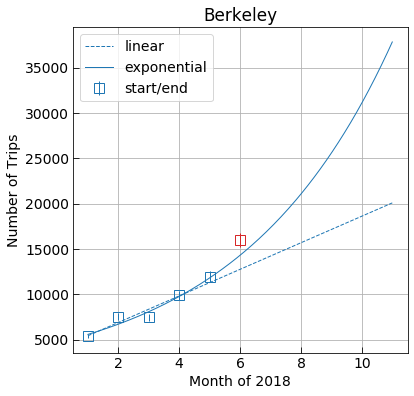

In [27]:
# Same as above, except exclude the June point from the fit.
from scipy.optimize import curve_fit
pf_lin, cov_lin = curve_fit(lambda t,a,b: a*t+b,  range(1,6),  n_berk_trips[1:][:-1],
          sigma=np.array(n_berk_trips[1:][:-1])*0.05, p0=(1500., 3500.))
pf_exp, cov_exp = curve_fit(lambda t,a,b,c: c + a*np.exp(b*t),  range(1,6),  n_berk_trips[1:][:-1],
          sigma=np.array(n_berk_trips[1:][:-1])*0.05, p0=(700., 0.45, 5000.))

fit_lin = pf_lin[0]*np.arange(1.,6.) + pf_lin[1]
fit_exp = pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*np.arange(1.,6.))

chi2_red_lin = np.sum(((n_berk_trips[1:][:-1] - fit_lin)/(np.array(n_berk_trips[1:][:-1])*0.05))**2)/(6 - 2)
chi2_red_exp = np.sum(((n_berk_trips[1:][:-1] - fit_exp)/(np.array(n_berk_trips[1:][:-1])*0.05))**2)/(6 - 2)
print("Reduced chi^2, lin. fit = %.3f" % chi2_red_lin)
print("Reduced chi^2, exp. fit = %.3f" % chi2_red_exp)

t_extrap = np.linspace(1., 11., 250)
plt.figure(figsize=(6,6))
plt.errorbar(range(1,6), n_berk_trips[1:][:-1], yerr=np.array(n_berk_trips[1:][:-1])*0.05,
             label='start/end', color='C0', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
# Show the omitted data point in red, just for comparison.
plt.errorbar(6, n_berk_trips[1:][-1], yerr=np.array(n_berk_trips[1:][-1])*0.05,
             color='C3', marker='s', markersize=ms, linestyle='None', markerfacecolor='None')
plt.plot(t_extrap, pf_lin[0]*t_extrap + pf_lin[1], color='C0', linestyle='--', label='linear')
plt.plot(t_extrap, pf_exp[2] + pf_exp[0]*np.exp(pf_exp[1]*t_extrap), color='C0', label='exponential')
plt.ylabel("Number of Trips")
plt.xlabel("Month of 2018")
plt.title("Berkeley")
plt.legend(numpoints=1)
plt.grid()
plt.show()

Even when excluding June an exponential function still appears to describe the data better than a linear function, but the rise in trips is slower when based on only the first five months of 2018.

So, depending on whether we include that June 2018 point, we get very different predictions for the number of start/end Berkeley trips that will be taken in October 2018 assuming exponential growth: either ~31,000 or nearly 48,000, respectively for the two cases. Time will tell if one (or neither) is correct!

### Time Distributions

Date and time statistics are also included, so we can figure out the bike usage as a function of time of day, day of week, and also average trip duration.

In [32]:
# Average trip duration.
avg_durations_all = [np.mean(tables[ii]['duration_sec']/60.) for ii in range(len(tables))]
avg_durations_berk = [np.mean(berk_trip_list[ii][0]['duration_sec']/60.) for ii in range(len(berk_trip_list))] # [minutes]
print("Average trip durations (minutes)")
print("Epoch     :    2017   01/18  02/18  03/18  04/18  05/18  06/18")
print("All cities: ", np.round(avg_durations_all, decimals=2))
print("Berkeley  : ", np.round(avg_durations_berk, decimals=2))

Average trip durations (minutes)
Epoch     :    2017   01/18  02/18  03/18  04/18  05/18  06/18
All cities:  [ 18.32  14.52  14.64  14.51  14.77  14.25  15.13]
Berkeley  :  [ 21.74  14.76  14.77  13.67  14.89  14.8   14.85]


With an average trip duration of just under 15 minutes, Berkeley falls right in line with the rest of the Bay Area. Trips were 4-5 minutes longer in 2017 than 2018, which is intriguing, but for now we'll file it away as a curiosity and move on.

Next we'll look at how trips are distributed over the days of the week.

Weekday average = 15.3%
Weekend average = 11.7%


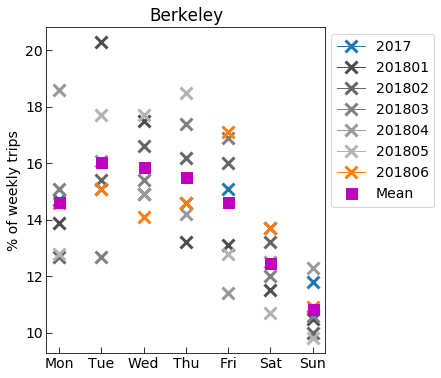

In [33]:
epoch_colors = ['C0', '0.3', '0.4', '0.5', '0.6', '0.7', 'C1']
epochs_by_day = []
fig = plt.figure(figsize=(5,6))
ax = plt.subplot(111)
for ep in range(0,7):
    epochs_by_day.append([])
    for dd, day in enumerate(days_of_week):
        if (dd==0):
            lab = epoch_names[ep]
        else:
            lab = None
        percent_trips = np.round(100*len(berk_trip_list[ep][0][berk_trip_list[ep][0]['start_day']==day])/len(berk_trip_list[ep][0]), decimals=1)
        #print(day, percent_trips)
        epochs_by_day[ep].append(percent_trips)
        ax.plot(dd, percent_trips, marker='x', color=epoch_colors[ep], markersize=ms+2, markeredgewidth=3, label=lab)
    #print("\n")
ax.set_ylabel("% of weekly trips")
ax.set_xticks(range(0,7))
ax.set_title("Berkeley")
ax.set_xticklabels(days_of_week)

# Get mean percentages for each day across all epochs.
mean_by_day = np.mean(epochs_by_day, axis=0)
print("Weekday average = %.1f%%" % np.mean(mean_by_day[0:5]))
print("Weekend average = %.1f%%" % np.mean(mean_by_day[5:]))

ax.plot(range(0,7), mean_by_day, marker='s', color='m', markersize=ms+1, linestyle='None', label='Mean')

ax.legend(numpoints=1, loc=(1.02,0.45))
plt.draw()

People are using GoBikes primarily on weekdays, with rides peaking on Tuesdays (16.5% of weekly rides) and declining through Friday, then really dropping off over the weekend. Mondays are a bit lackluster, which could be due to holidays and people taking long weekends (Friday is the next lowest weekday) or maybe a preference for other transportation to start the work week. Still, the number of trips is fairly constant across weekdays while weekend usage is significantly lower: ridership drops by ~28% compared to weekdays.

I take this split to mean that work-related uses (e.g. daily commutes) make up an important fraction of trips. It's especially notable given that public transportation typically runs less frequently and during fewer hours on weekends, which might boost bikeshare usage during that time.

We can test the commuter hypothesis by examining trip number as a function of start/end time.

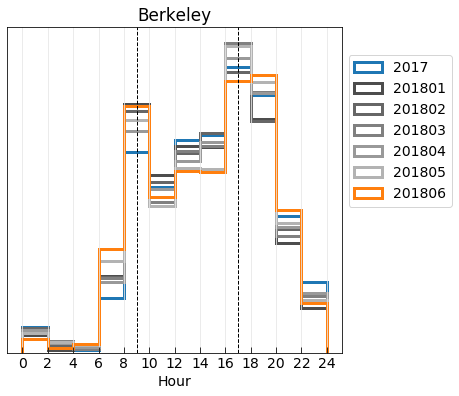

In [38]:
hists = []
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for ep in range(0,7):
    histout = ax.hist(berk_trip_list[ep][0]['start_hr'], bins=np.arange(0, 25, 2), histtype='step', color=epoch_colors[ep],
            linewidth=3, density=True, label=epoch_names[ep])
    hists.append(histout)
#ax.hist(np.mean([hists[ii][0] for ii in range(0,7)], axis=0), range=(0, 25), density=True, histtype='step', color='m',
#            linewidth=3, label='Mean')
ax.yaxis.set_visible(False)
ax.set_xticks(np.arange(0, 25, 2))
ax.grid(which='major', axis='x', c='0.9')
ax.axvline(x=9, color='k', linestyle='--')
ax.axvline(x=17, color='k', linestyle='--')
ax.set_xlabel("Hour")
ax.set_title("Berkeley")
ax.legend(numpoints=1, loc=(1.02,0.45))
plt.draw()

Indeed, the trips peak during the morning and afternoon commutes (dashed lines mark 9 AM and 5 PM). The distribution of trip end times is basically the same, so I won't bother plotting it (this makes sense given the 15 minute average trip time).

### Rider Demographics

Rider birthdate and gender are collected for most trips, so we can partially examine those aspects of the people using the GoBike system.

In [40]:
# To Do: Look at rider age?? Change over time??

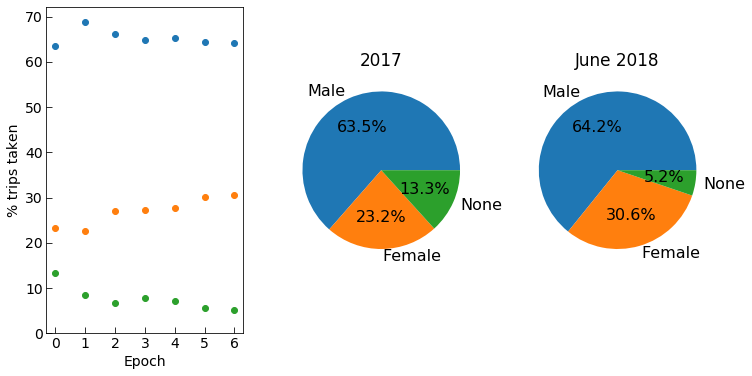

In [79]:
# Compare Berkeley trip-takers by gender.
gender_labels = ['Male', 'Female', 'None']
genders = ['Male', 'Female', '']
berk_trips_m_f = []
plt.figure(figsize=(12,6))
ax0 = plt.subplot(131)
for ep in range(0,7):
    berk_trips_m_f.append([len(berk_trip_list[ep][0][berk_trip_list[ep][0]['member_gender'] == gen]) for gen in genders])
    ax0.plot(ep, 100*berk_trips_m_f[-1][0]/np.sum(berk_trips_m_f[-1]), c='C0', marker='o', label='Male')
    ax0.plot(ep, 100*berk_trips_m_f[-1][1]/np.sum(berk_trips_m_f[-1]), c='C1', marker='o', label='Female')
    ax0.plot(ep, 100*berk_trips_m_f[-1][2]/np.sum(berk_trips_m_f[-1]), c='C2', marker='o', label='None')
    #print("Epoch", ep)
    #print(100*berk_trips_m_f[-1][0]/np.sum(berk_trips_m_f[-1]))
    #print(100*berk_trips_m_f[-1][1]/np.sum(berk_trips_m_f[-1]))
    #print(100*berk_trips_m_f[-1][2]/np.sum(berk_trips_m_f[-1]))
ax0.set_yticks(np.arange(0,80,10))
ax0.set_xticks(np.arange(0,7,1))
ax0.set_ylabel("% trips taken")
ax0.set_xlabel("Epoch")
#ax0.legend(numpoints=1)

# Draw pie charts of gender distribution.
ax1 = plt.subplot(132)
ax1.pie(berk_trips_m_f[0], labels=gender_labels, autopct='%.1f%%', textprops={'fontsize':16},
       startangle=0)
ax1.set_aspect('equal')
ax1.set_title("2017")
ax2 = plt.subplot(133)
ax2.pie(berk_trips_m_f[-1], labels=gender_labels, autopct='%.1f%%', textprops={'fontsize':16},
       startangle=0)
ax2.set_aspect('equal')
ax2.set_title("June 2018")
plt.draw()

Interestingly, more women are using GoBike over time. The Male/Female/None user percentages have changed from 68.6/20.3/11.0% in 2017 to 64.0/30.4/5.6% in June 2018. The fraction of riders with no reported gender ("None") has also decreased over this time, so some of the "new" female riders may not be new at all but just newly reporting as female. Still, this can't account for all of the increase in female ridership or the simultaneous decrease in male ridership. 

Did women hesitate to use the service for some reason when it first arrived? Maybe GoBike's advertisements didn't reach women as effectively as men early on? Or, because stations were added to the system incrementally, perhaps the original stations were located in areas more frequently trafficked by men?

This last question might be something we can explore further with our data by breaking down trips according to station location.

### Location Usage

Which stations are most heavily used? How do they break down by gender and age? How has station usage changed with time?

In [77]:
# The useful collections.Counter function returns a nice dictionary with the number of occurrences for each station id.
from collections import Counter
start_station_counts = Counter(np.array(tables[-1]['start_station_id']))
end_station_counts = Counter(np.array(tables[-1]['end_station_id']))
start_station_berk_counts = Counter(np.array(berk_trip_list[-1][0]['start_station_id']))
end_station_berk_counts = Counter(np.array(berk_trip_list[-1][0]['end_station_id']))
start_coords = []
end_coords = []

# Even more handy, the Counter dict has a special method to return the N most common elements.
print("\nTop 10 starting stations (Berkeley trips only):")
for ss in start_station_berk_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))

print("\nTop 10 ending stations (Berkeley trips only):")
for ss in end_station_berk_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))

print("\nTop 10 starting stations (entire network):")
for ss in start_station_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))
        start_coords.append((stations[stations['id']==ss[0]]['lat'].data[0], stations[stations['id']==ss[0]]['lon'].data[0]))

print("\nTop 10 ending stations (entire network):")
for ss in end_station_counts.most_common(10):
    if ss[0] > -1:
        print("\t%s, %s: %d rides" % (stations[stations['id']==ss[0]]['city'].data[0], stations[stations['id']==ss[0]]['name'].data[0], ss[1]))
        end_coords.append((stations[stations['id']==ss[0]]['lat'].data[0], stations[stations['id']==ss[0]]['lon'].data[0]))


Top 10 starting stations (Berkeley trips only):
	Berkeley, Bancroft Way at College Ave: 1163 rides
	Berkeley, Bancroft Way at Telegraph Ave: 995 rides
	Berkeley, Downtown Berkeley BART: 913 rides
	Berkeley, Ashby BART Station: 850 rides
	Berkeley, Hearst Ave at Euclid Ave: 661 rides
	Berkeley, Derby St at College Ave: 616 rides
	Berkeley, Haste St at Telegraph Ave: 594 rides
	Berkeley, Berkeley Civic Center: 518 rides
	Berkeley, Parker St at Fulton St: 468 rides
	Berkeley, College Ave at Alcatraz Ave: 443 rides

Top 10 ending stations (Berkeley trips only):
	Berkeley, Downtown Berkeley BART: 1595 rides
	Berkeley, Ashby BART Station: 865 rides
	Berkeley, Bancroft Way at Telegraph Ave: 859 rides
	Berkeley, Berkeley Civic Center: 617 rides
	Oakland, Rockridge BART Station: 548 rides
	Berkeley, Addison St at Fourth St: 543 rides
	Berkeley, Parker St at Fulton St: 488 rides
	Berkeley, Derby St at College Ave: 470 rides
	Berkeley, Haste St at Telegraph Ave: 434 rides
	Berkeley, MLK Jr Way a

Unsurprisingly, the most heavily used Berkeley stations are near the UC Berkeley campus and at BART stations. Other hotspots include downtown Berkeley (e.g., the Civic Center) and food centers (e.g., Telegraph Ave on campus' southside, and College Ave & Alcatraz Ave near a Safeway and other markets/shops. The 4th St. area also gets attention, though the main attractor there may be the Amtrak station; most rides start or end at 4th & Addison (near the station) rather than at 5th & Delaware (closer to the shops). A couple of the remaining stations seem to be in mostly residential areas that may house lots of UC Berkeley students: Parker St. & Fulton St. and Derby St. & College Ave (with the latter also being the site of Sack's Coffee House).

There are other things to look into: the least-used stations, gender splits at stations, times of use at stations, and more that I haven't thought of yet.

